# Bert baseline for POLAR

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Imports

In [1]:
pip install iterative-stratification

In [2]:
import pandas as pd
import re
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [3]:
from google.colab import userdata
#userdata.get('wandb')

In [4]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [6]:
data = pd.read_csv('/content/drive/MyDrive/subtask2/train/hau.csv')
dev = pd.read_csv('/content/drive/MyDrive/subtask2/dev/hau.csv')
#train.head()

In [7]:
data

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,hau_d46daddeae8ef401d7238069b184a426,@USER ipob bandits how inyamiri you beheaded &...,0,0,0,0,0
1,hau_782aae239d5b3fe2c94361058fe88540,@USER to ko a somalian in kaga mace da abaya y...,0,0,0,0,0
2,hau_7779f971d0c4b9e44637afe9034d56a2,@USER wai daman ke ba inyamura bace🤔,0,0,0,0,0
3,hau_cc97b6b83c66c74914115b56a0c23ebd,@USER mesa mu musulmai muke da neman rigima ne...,0,0,0,0,0
4,hau_44fad6b3535d91396593e8947158515a,lmao. sankara ko sakara ni. ##url,0,0,0,0,0
...,...,...,...,...,...,...,...
3646,hau_c7971dbbc3964b78a72ed433344d7a5c,@USER kaji dan shegiya.,0,0,0,0,0
3647,hau_5445c6da2f2ff00c2e40f60bec4dd6b5,Wani dan Addinin Tijjaniya yace dani. “Jahilin...,0,0,1,0,0
3648,hau_e7c741eef668345f710023554648bf5f,"we supported him we campaigned for him, we vot...",0,0,0,0,0
3649,hau_95b74ecd753fe42c4ea40a2d57050f63,"Cry me river , wawa ,hege Dan hegiya akuya the...",0,0,1,0,0


political        178
racial/ethnic    115
religious         93
gender/sexual     29
other             14
dtype: int64
political        4.88
racial/ethnic    3.15
religious        2.55
gender/sexual    0.79
other            0.38
dtype: float64


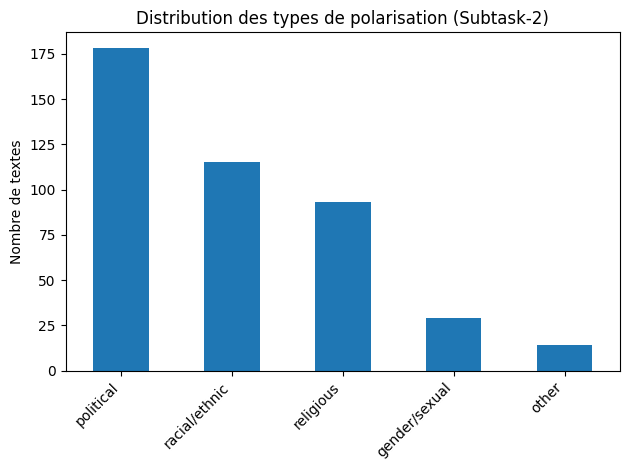

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
label_counts = data[label_cols].sum().sort_values(ascending=False)
print(label_counts)
label_percent = (label_counts / len(data)) * 100
print(label_percent.round(2))
plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution des types de polarisation (Subtask-2)")
plt.ylabel("Nombre de textes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:
data["is_polarized"] = data[label_cols].sum(axis=1) > 0

non_polarized_count = (~data["is_polarized"]).sum()
polarized_count = data["is_polarized"].sum()

print("Textes polarisés :", polarized_count)
print("Textes non polarisés :", non_polarized_count)
print("Pourcentage non polarisé :", round(non_polarized_count / len(data) * 100, 2), "%")


Textes polarisés : 392
Textes non polarisés : 3259
Pourcentage non polarisé : 89.26 %


In [10]:
data["num_labels"] = data[label_cols].sum(axis=1)
data["num_labels"].value_counts().sort_index()
(data["num_labels"].value_counts(normalize=True) * 100).sort_index().round(2)
co_occurrence = pd.DataFrame(
    0, index=label_cols, columns=label_cols
)

for col1 in label_cols:
    for col2 in label_cols:
        co_occurrence.loc[col1, col2] = ((data[col1] == 1) & (data[col2] == 1)).sum()

print(co_occurrence)


               political  racial/ethnic  religious  gender/sexual  other
political            178             11         13              3      0
racial/ethnic         11            115          5              3      0
religious             13              5         93              2      0
gender/sexual          3              3          2             29      0
other                  0              0          0              0     14


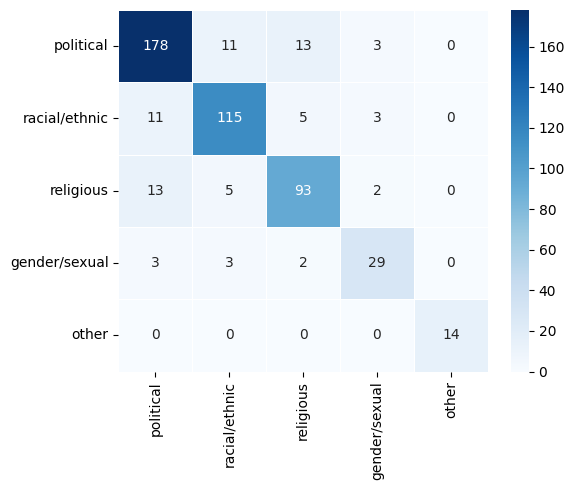

In [13]:
import seaborn as sns

co_occurrence = data[label_cols].T.dot(data[label_cols])  # co-occurrence matrix

plt.figure(figsize=(6,5))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.tight_layout()
plt.savefig("cooccurrence_hau.pdf", bbox_inches="tight")
plt.show()


In [12]:
top

NameError: name 'top' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data[label_cols].corr()
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des types de polarisation')
plt.show()

In [ ]:
data["text_length"] = data["text"].str.split().str.len()
data.groupby("is_polarized")["text_length"].describe()

In [ ]:
#data = data[data.is_polarized == False]

In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

X = data
y = data[label_cols].values

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=2
)

train_idx, val_idx = next(msss.split(X, y))

train = data.iloc[train_idx].reset_index(drop=True)
val = data.iloc[val_idx].reset_index(drop=True)


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# ============================================================
# CONFIGURATION
# ============================================================
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed: int):
    """Set seed for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    try:
        import transformers
        transformers.set_seed(seed)
    except ImportError:
        pass

set_seed(SEED)

# ============================================================
# DATASET CLASS
# ============================================================
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

# ============================================================
# CUSTOM TRAINER WITH WEIGHTED LOSS
# ============================================================
class WeightedBCETrainer(Trainer):
    """Trainer avec loss pondérée pour gérer le déséquilibre des classes"""

    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use weighted BCE loss if pos_weights provided
        if self.pos_weights is not None:
            pos_weight = torch.tensor(self.pos_weights).to(logits.device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            loss_fct = torch.nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# ============================================================
# METRICS FUNCTIONS WITH THRESHOLD OPTIMIZATION
# ============================================================
def compute_metrics_with_optimal_threshold(eval_pred, num_labels=1,
                                          threshold_range=(0.3, 0.7)):
    """
    Compute metrics and find optimal threshold for each label
    """
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    if num_labels == 1:
        # Single label - find best threshold
        best_f1 = 0
        best_threshold = 0.5

        for threshold in np.arange(threshold_range[0], threshold_range[1], 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='binary', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        preds_best = (probs > best_threshold).astype(int)

        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, average='binary', zero_division=0),
            'recall': recall_score(labels, preds_best, average='binary', zero_division=0),
            'best_threshold': best_threshold
        }
    else:
        # Multi-label - find best threshold per label
        best_thresholds = []
        f1_scores = []

        for i in range(num_labels):
            best_f1 = 0
            best_threshold = 0.5

            for threshold in np.arange(threshold_range[0], threshold_range[1], 0.05):
                preds = (probs[:, i] > threshold).astype(int)
                f1 = f1_score(labels[:, i], preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            best_thresholds.append(best_threshold)
            f1_scores.append(best_f1)

        # Apply best thresholds
        preds_best = np.zeros_like(probs)
        for i in range(num_labels):
            preds_best[:, i] = (probs[:, i] > best_thresholds[i]).astype(int)

        return {
            'f1_macro': f1_score(labels, preds_best, average='macro', zero_division=0),
            'f1_scores': f1_scores,
            'best_thresholds': best_thresholds
        }


def train_models(data, val_data=None):
    """
    Train separate models for political and other labels

    Args:
        data: Training dataframe
        val_data: Validation dataframe (optional, will split if not provided)
    """

    label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

    # Split data if validation not provided
    if val_data is None:
        X = data
        y = data[label_cols].values

        msss = MultilabelStratifiedShuffleSplit(
            n_splits=1,
            test_size=0.15,
            random_state=SEED
        )

        train_idx, val_idx = next(msss.split(X, y))
        train_data = data.iloc[train_idx].reset_index(drop=True)
        val_data = data.iloc[val_idx].reset_index(drop=True)
    else:
        train_data = data

    print("\n" + "="*70)
    print("CONFIGURATION DES DONNÉES")
    print("="*70)
    print(f"Train samples: {len(train_data)}")
    print(f"Val samples: {len(val_data)}")
    print(f"\nDistribution des labels (train):")
    for col in label_cols:
        pos = train_data[col].sum()
        pct = pos / len(train_data) * 100
        print(f"  {col:20s}: {pos:4d} ({pct:5.2f}%)")


    print("\n" + "="*70)
    print("ENTRAÎNEMENT MODÈLE POLITICAL")
    print("="*70)

    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Calculate class weights for political label
    y_train_political = train_data["political"].values
    class_weights_political = compute_class_weight(
        'balanced',
        classes=np.array([0, 1]),
        y=y_train_political
    )
    pos_weight_political = class_weights_political[1] / class_weights_political[0]

    print(f"\nClass weights for POLITICAL:")
    print(f"  Negative class weight: {class_weights_political[0]:.3f}")
    print(f"  Positive class weight: {class_weights_political[1]:.3f}")
    print(f"  Pos weight ratio: {pos_weight_political:.3f}")

    # Create datasets
    train_dataset_political = PolarizationDataset(
        train_data['text'].tolist(),
        train_data[["political"]].values.tolist(),
        tokenizer
    )
    val_dataset_political = PolarizationDataset(
        val_data['text'].tolist(),
        val_data[["political"]].values.tolist(),
        tokenizer
    )

    # Initialize model
    config_political = AutoConfig.from_pretrained(model_name)
    config_political.num_labels = 1
    config_political.problem_type = "multi_label_classification"

    model_political = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config_political
    )
    model_political.to(device)

    # Training arguments - OPTIMISÉS
    training_args_political = TrainingArguments(
        output_dir='./results_political',
        num_train_epochs=5,  # Plus d'epochs
        learning_rate=2e-5,  # Learning rate optimal
        per_device_train_batch_size=16,  # Batch size réduit
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,  # Warmup pour stabilité
        weight_decay=0.01,
        save_total_limit=2,
        seed=SEED,
    )

    # Trainer with weighted loss
    trainer_political = WeightedBCETrainer(
        model=model_political,
        args=training_args_political,
        train_dataset=train_dataset_political,
        eval_dataset=val_dataset_political,
        compute_metrics=lambda p: compute_metrics_with_optimal_threshold(p, num_labels=1),
        data_collator=DataCollatorWithPadding(tokenizer),
        pos_weights=[pos_weight_political]
    )

    # Train
    print("\nDébut entraînement modèle POLITICAL...")
    trainer_political.train()

    # Evaluate
    eval_results_political = trainer_political.evaluate()
    print("\n" + "="*70)
    print("RÉSULTATS MODÈLE POLITICAL")
    print("="*70)
    for key, value in eval_results_political.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")


    print("\n" + "="*70)
    print("ENTRAÎNEMENT MODÈLE OTHER LABELS")
    print("="*70)

    other_labels = ["racial/ethnic", "religious", "gender/sexual", "other"]

    # Calculate pos weights for each label
    pos_weights_other = []
    for label in other_labels:
        y_train_label = train_data[label].values
        weights = compute_class_weight(
            'balanced',
            classes=np.array([0, 1]),
            y=y_train_label
        )
        pos_weight = weights[1] / weights[0]
        pos_weights_other.append(pos_weight)
        print(f"  {label:20s} pos_weight: {pos_weight:.3f}")

    # Create datasets
    train_dataset_other = PolarizationDataset(
        train_data['text'].tolist(),
        train_data[other_labels].values.tolist(),
        tokenizer
    )
    val_dataset_other = PolarizationDataset(
        val_data['text'].tolist(),
        val_data[other_labels].values.tolist(),
        tokenizer
    )

    # Initialize model
    config_other = AutoConfig.from_pretrained(model_name)
    config_other.num_labels = 4
    config_other.problem_type = "multi_label_classification"

    model_other = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config_other
    )
    model_other.to(device)

    # Training arguments
    training_args_other = TrainingArguments(
        output_dir='./results_other',
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,
        weight_decay=0.01,
        save_total_limit=2,
        seed=SEED,
    )

    # Trainer with weighted loss
    trainer_other = WeightedBCETrainer(
        model=model_other,
        args=training_args_other,
        train_dataset=train_dataset_other,
        eval_dataset=val_dataset_other,
        compute_metrics=lambda p: compute_metrics_with_optimal_threshold(p, num_labels=4),
        data_collator=DataCollatorWithPadding(tokenizer),
        pos_weights=pos_weights_other
    )

    # Train
    print("\nDébut entraînement modèle OTHER LABELS...")
    trainer_other.train()

    # Evaluate
    eval_results_other = trainer_other.evaluate()
    print("\n" + "="*70)
    print("RÉSULTATS MODÈLE OTHER LABELS")
    print("="*70)
    for key, value in eval_results_other.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        elif isinstance(value, list):
            print(f"  {key}:")
            for i, v in enumerate(value):
                print(f"    {other_labels[i]:20s}: {v:.4f}")
        else:
            print(f"  {key}: {value}")

    return trainer_political, trainer_other, val_dataset_political, val_dataset_other

def combine_predictions(trainer_political, trainer_other,
                       val_dataset_political, val_dataset_other,
                       threshold_political=None, threshold_other=None):
    """
    Combine predictions from both models
    """
    print("\n" + "="*70)
    print("COMBINAISON DES PRÉDICTIONS")
    print("="*70)

    # Get predictions
    pred_output_political = trainer_political.predict(val_dataset_political)
    pred_output_other = trainer_other.predict(val_dataset_other)

    logits_political = pred_output_political.predictions
    labels_political = pred_output_political.label_ids

    logits_other = pred_output_other.predictions
    labels_other = pred_output_other.label_ids

    # Reshape if needed
    if logits_political.ndim == 1:
        logits_political = logits_political.reshape(-1, 1)
    if labels_political.ndim == 1:
        labels_political = labels_political.reshape(-1, 1)

    # Combine
    combined_logits = np.concatenate((logits_political, logits_other), axis=1)
    combined_labels = np.concatenate((labels_political, labels_other), axis=1)
    combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()

    print(f"\nShapes après combinaison:")
    print(f"  combined_probs: {combined_probs.shape}")
    print(f"  combined_labels: {combined_labels.shape}")

    # Use provided thresholds or find optimal ones
    label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

    if threshold_political is None or threshold_other is None:
        print("\nRecherche des seuils optimaux...")
        best_thresholds = []

        for i, label in enumerate(label_cols):
            best_f1 = 0
            best_threshold = 0.5

            for threshold in np.arange(0.2, 0.8, 0.05):
                preds = (combined_probs[:, i] > threshold).astype(int)
                f1 = f1_score(combined_labels[:, i], preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            best_thresholds.append(best_threshold)
            print(f"  {label:20s}: optimal threshold = {best_threshold:.2f} (F1 = {best_f1:.3f})")
    else:
        best_thresholds = [threshold_political] + [threshold_other] * 4

    # Apply thresholds
    combined_preds = np.zeros_like(combined_probs)
    for i in range(5):
        combined_preds[:, i] = (combined_probs[:, i] > best_thresholds[i]).astype(int)

    # Calculate final metrics
    print("\n" + "="*70)
    print("RÉSULTATS FINAUX COMBINÉS")
    print("="*70)

    f1_macro = f1_score(combined_labels, combined_preds, average='macro', zero_division=0)
    print(f"\nMacro F1 score: {f1_macro:.4f}")

    print(f"\nScores individuels par label:")
    print(f"{'Label':<20} {'F1':<8} {'Precision':<12} {'Recall':<10} {'Threshold':<10}")
    print("-" * 70)

    for i, label in enumerate(label_cols):
        f1 = f1_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
        prec = precision_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
        rec = recall_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
        print(f"{label:<20} {f1:<8.3f} {prec:<12.3f} {rec:<10.3f} {best_thresholds[i]:<10.2f}")

    return combined_preds, combined_probs, best_thresholds


if __name__ == "__main__":
    print("\n" + "="*70)
    print("Script terminé avec succès!")
    print("="*70)

In [ ]:
class WeightedBCETrainer(Trainer):
    """Trainer avec loss pondérée pour gérer le déséquilibre des classes"""

    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use weighted BCE loss
        if self.pos_weights is not None:
            pos_weight = torch.tensor(self.pos_weights).to(logits.device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            loss_fct = torch.nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

def compute_metrics_optimal_threshold(eval_pred):
    """Trouve le seuil optimal pour maximiser F1"""
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Pour un seul label
    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.flatten()
        labels = labels.flatten()

        best_f1 = 0
        best_threshold = 0.5

        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        preds_best = (probs > best_threshold).astype(int)

        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, zero_division=0),
            'recall': recall_score(labels, preds_best, zero_division=0),
            'threshold': best_threshold
        }

    # Pour plusieurs labels
    else:
        best_f1_macro = 0
        best_thresholds = [0.5] * probs.shape[1]

        # Chercher les meilleurs seuils
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)
            if f1 > best_f1_macro:
                best_f1_macro = f1
                best_thresholds = [threshold] * probs.shape[1]

        preds_best = (probs > best_thresholds[0]).astype(int)

        return {
            'f1_macro': best_f1_macro,
            'threshold': best_thresholds[0]
        }

print("="*70)
print("CONFIGURATION MODÈLE POLITICAL")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe pour political
y_train_political = train["political"].values
class_weights_political = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=y_train_political
)
pos_weight_political = class_weights_political[1] / class_weights_political[0]

print(f"\nClass weights for POLITICAL:")
print(f"  Negative: {class_weights_political[0]:.3f}")
print(f"  Positive: {class_weights_political[1]:.3f}")
print(f"  Pos weight ratio: {pos_weight_political:.3f}")

# Charger le modèle et tokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Créer le modèle POLITICAL
config_political = AutoConfig.from_pretrained(model_name)
config_political.num_labels = 1
config_political.problem_type = "multi_label_classification"

model_political = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config_political
)
model_political.to(device)

# Créer les datasets
train_dataset_political = PolarizationDataset(
    train['text'].tolist(),
    train[["political"]].values.tolist(),
    tokenizer
)
val_dataset_political = PolarizationDataset(
    val['text'].tolist(),
    val[["political"]].values.tolist(),
    tokenizer
)

# Arguments d'entraînement OPTIMISÉS
training_args_political = TrainingArguments(
    output_dir='./results_political',
    num_train_epochs=5,  # Plus d'epochs !
    learning_rate=2e-5,  # Learning rate optimal
    per_device_train_batch_size=16,  # Batch size réduit
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=50,
    warmup_ratio=0.1,  # Warmup pour stabilité !
    weight_decay=0.01,
    save_total_limit=2,
    seed=42,
)

# Créer le trainer avec WEIGHTED LOSS
trainer_political = WeightedBCETrainer(
    model=model_political,
    args=training_args_political,
    train_dataset=train_dataset_political,
    eval_dataset=val_dataset_political,
    compute_metrics=compute_metrics_optimal_threshold,
    data_collator=DataCollatorWithPadding(tokenizer),
    pos_weights=[pos_weight_political]  # IMPORTANT !
)

# ENTRAÎNER
print("\n" + "="*70)
print("DÉBUT ENTRAÎNEMENT MODÈLE POLITICAL")
print("="*70)
trainer_political.train()

# ÉVALUER
eval_results_political = trainer_political.evaluate()
print("\n" + "="*70)
print("RÉSULTATS MODÈLE POLITICAL")
print("="*70)
for key, value in eval_results_political.items():
    print(f"  {key}: {value}")


print("\n" + "="*70)
print("CONFIGURATION MODÈLE OTHER LABELS")
print("="*70)

other_labels = ["racial/ethnic", "religious", "gender/sexual", "other"]

# Calculer pos_weights pour chaque label
pos_weights_other = []
for label in other_labels:
    y_train_label = train[label].values
    weights = compute_class_weight(
        'balanced',
        classes=np.array([0, 1]),
        y=y_train_label
    )
    pos_weight = weights[1] / weights[0]
    pos_weights_other.append(pos_weight)
    print(f"  {label:20s} pos_weight: {pos_weight:.3f}")

# Créer le modèle OTHER
config_other = AutoConfig.from_pretrained(model_name)
config_other.num_labels = 4
config_other.problem_type = "multi_label_classification"

model_other = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config_other
)
model_other.to(device)

# Créer les datasets
train_dataset_other = PolarizationDataset(
    train['text'].tolist(),
    train[other_labels].values.tolist(),
    tokenizer
)
val_dataset_other = PolarizationDataset(
    val['text'].tolist(),
    val[other_labels].values.tolist(),
    tokenizer
)

# Arguments d'entraînement
training_args_other = TrainingArguments(
    output_dir='./results_other',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    warmup_ratio=0.1,
    weight_decay=0.01,
    save_total_limit=2,
    seed=42,
)

# Créer le trainer avec WEIGHTED LOSS
trainer_other = WeightedBCETrainer(
    model=model_other,
    args=training_args_other,
    train_dataset=train_dataset_other,
    eval_dataset=val_dataset_other,
    compute_metrics=compute_metrics_optimal_threshold,
    data_collator=DataCollatorWithPadding(tokenizer),
    pos_weights=pos_weights_other  # IMPORTANT !
)

# ENTRAÎNER
print("\n" + "="*70)
print("DÉBUT ENTRAÎNEMENT MODÈLE OTHER LABELS")
print("="*70)
trainer_other.train()

# ÉVALUER
eval_results_other = trainer_other.evaluate()
print("\n" + "="*70)
print("RÉSULTATS MODÈLE OTHER LABELS")
print("="*70)
for key, value in eval_results_other.items():
    print(f"  {key}: {value}")

# ============================================================
# COMBINAISON DES PRÉDICTIONS
# ============================================================
print("\n" + "="*70)
print("COMBINAISON DES PRÉDICTIONS")
print("="*70)

# Get predictions
pred_output_political = trainer_political.predict(val_dataset_political)
pred_output_other = trainer_other.predict(val_dataset_other)

logits_political = pred_output_political.predictions
labels_political = pred_output_political.label_ids

logits_other = pred_output_other.predictions
labels_other = pred_output_other.label_ids

# Reshape si nécessaire
if logits_political.ndim == 1:
    logits_political = logits_political.reshape(-1, 1)
if labels_political.ndim == 1:
    labels_political = labels_political.reshape(-1, 1)

# Combiner
combined_logits = np.concatenate((logits_political, logits_other), axis=1)
combined_labels = np.concatenate((labels_political, labels_other), axis=1)
combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()

print(f"\nShapes après combinaison:")
print(f"  combined_probs: {combined_probs.shape}")
print(f"  combined_labels: {combined_labels.shape}")

# Trouver les seuils optimaux pour chaque label
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

print("\nRecherche des seuils optimaux par label...")
best_thresholds = []

for i, label in enumerate(label_cols):
    best_f1 = 0
    best_threshold = 0.5

    for threshold in np.arange(0.2, 0.8, 0.05):
        preds = (combined_probs[:, i] > threshold).astype(int)
        f1 = f1_score(combined_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    best_thresholds.append(best_threshold)
    print(f"  {label:20s}: seuil optimal = {best_threshold:.2f} (F1 = {best_f1:.3f})")

# Appliquer les seuils optimaux
combined_preds = np.zeros_like(combined_probs)
for i in range(5):
    combined_preds[:, i] = (combined_probs[:, i] > best_thresholds[i]).astype(int)

# Calculer les métriques finales
print("\n" + "="*70)
print("RÉSULTATS FINAUX")
print("="*70)

f1_macro = f1_score(combined_labels, combined_preds, average='macro', zero_division=0)
print(f"\nMacro F1 score: {f1_macro:.4f}")

print(f"\nScores individuels:")
print(f"{'Label':<20} {'F1':<8} {'Precision':<12} {'Recall':<10} {'Seuil':<10}")
print("-" * 70)

for i, label in enumerate(label_cols):
    f1 = f1_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
    prec = precision_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
    rec = recall_score(combined_labels[:, i], combined_preds[:, i], zero_division=0)
    print(f"{label:<20} {f1:<8.3f} {prec:<12.3f} {rec:<10.3f} {best_thresholds[i]:<10.2f}")

print("\n" + "="*70)
print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS")
print("="*70)

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
import random
import numpy as np
import torch

def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in `random`, `numpy`, `torch` and optionally `transformers`"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # if you are using transformers library, this is also useful
    try:
        import transformers
        transformers.set_seed(seed)
    except ImportError:
        pass

# Set a random seed for reproducibility
SEED = 42
set_seed(SEED)
print(f"Random seed set to {SEED}")

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model (NON political labels only)
model_name = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    problem_type="multi_label_classification"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Labels kept (political removed)
columns_train = ["political",
    "racial/ethnic",
    "religious",
    "gender/sexual",
    "other"
]

# Create train / validation / dev datasets
train_dataset = PolarizationDataset(
    train["text"].tolist(),
    train[columns_train].values.tolist(),
    tokenizer
)

val_dataset = PolarizationDataset(
    val["text"].tolist(),
    val[columns_train].values.tolist(),
    tokenizer
)

dev_dataset = PolarizationDataset(
    dev["text"].tolist(),
    dev[columns_train].values.tolist(),
    tokenizer
)


In [ ]:
# Define metrics function for multi-label classification

def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.35).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}


# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)
trainer.train()
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

In [ ]:
trainer.train()
# Evaluate the model on the validation set
eval_results_political = trainer_political.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results_political['eval_f1_macro']}")
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

In [ ]:
# Get predictions from the political trainer
pred_output_political = trainer_political.predict(val_dataset_political)
logits_political = pred_output_political.predictions
labels_political = pred_output_political.label_ids

# Get predictions from the other labels trainer
pred_output_other = trainer.predict(val_dataset)
logits_other = pred_output_other.predictions
labels_other = pred_output_other.label_ids

# === DIAGNOSTIC DÉTAILLÉ DU MODÈLE POLITICAL ===
print("="*60)
print("DIAGNOSTIC DU MODÈLE POLITICAL")
print("="*60)

# Convertir logits political en probabilités
probs_political_only = torch.sigmoid(torch.tensor(logits_political)).numpy().flatten()

print(f"\nStatistiques des probabilités POLITICAL:")
print(f"  Min: {probs_political_only.min():.4f}")
print(f"  Max: {probs_political_only.max():.4f}")
print(f"  Mean: {probs_political_only.mean():.4f}")
print(f"  Median: {np.median(probs_political_only):.4f}")

print(f"\nDistribution des probabilités:")
print(f"  Prob > 0.85: {(probs_political_only > 0.85).sum()} échantillons")
print(f"  Prob > 0.70: {(probs_political_only > 0.70).sum()} échantillons")
print(f"  Prob > 0.50: {(probs_political_only > 0.50).sum()} échantillons")
print(f"  Prob > 0.30: {(probs_political_only > 0.30).sum()} échantillons")

print(f"\nVraies labels political:")
print(f"  Positifs: {labels_political.sum()} / {len(labels_political)} ({labels_political.mean()*100:.1f}%)")

print(f"\nTest de différents seuils pour POLITICAL SEUL:")
print(f"{'Seuil':<8} {'F1':<8} {'Precision':<12} {'Recall':<10} {'Pred_pos':<10}")
print("-" * 60)
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85]:
    preds_test = (probs_political_only > threshold).astype(int)
    f1 = f1_score(labels_political.flatten(), preds_test, zero_division=0)
    prec = precision_score(labels_political.flatten(), preds_test, zero_division=0)
    rec = recall_score(labels_political.flatten(), preds_test, zero_division=0)
    n_pos = preds_test.sum()
    print(f"{threshold:<8.2f} {f1:<8.3f} {prec:<12.3f} {rec:<10.3f} {n_pos:<10}")

print("="*60)

# === MAINTENANT LA COMBINAISON ===
# Concatenate the logits and labels along the label dimension
combined_logits = np.concatenate((logits_political, logits_other), axis=1)
combined_labels = np.concatenate((labels_political, labels_other), axis=1)

# Convert combined logits to probabilities using sigmoid
combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()

print(f"\n\nAPRÈS CONCATÉNATION:")
print(f"combined_probs shape: {combined_probs.shape}")
print(f"combined_labels shape: {combined_labels.shape}")

print(f"\nStatistiques colonne 0 (political) dans combined_probs:")
print(f"  Min: {combined_probs[:, 0].min():.4f}")
print(f"  Max: {combined_probs[:, 0].max():.4f}")
print(f"  Mean: {combined_probs[:, 0].mean():.4f}")
print(f"  Samples > 0.85: {(combined_probs[:, 0] > 0.85).sum()}")
print(f"  Samples > 0.5: {(combined_probs[:, 0] > 0.5).sum()}")

# UTILISER LE MEILLEUR SEUIL (probablement 0.5 ou moins)
BEST_THRESHOLD = 0.5  # Ajustez selon les résultats ci-dessus

# Apply thresholds to get binary predictions for each label
preds_political = (combined_probs[:, 0] > BEST_THRESHOLD).astype(int)
preds_other = (combined_probs[:, 1:] > 0.2).astype(int)

# Combine the binary predictions
combined_preds = np.concatenate((preds_political.reshape(-1, 1), preds_other), axis=1)

# Define all label column names in the correct order
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

# Compute macro F1 score on the combined predictions
f1_macro_combined = f1_score(combined_labels, combined_preds, average='macro', zero_division=0)

print(f"\n{'='*60}")
print(f"RÉSULTATS AVEC SEUIL {BEST_THRESHOLD} POUR POLITICAL")
print(f"{'='*60}")
print(f"Combined Macro F1 score: {f1_macro_combined:.3f}")

# Also print F1 for each individual label
print(f"\nIndividual F1 scores:")
print(f"{'Label':<20} {'F1':<8} {'Precision':<12} {'Recall':<10} {'Pred_pos':<10}")
print("-" * 60)
for i, label in enumerate(label_cols):
    threshold = BEST_THRESHOLD if label == "political" else 0.2
    preds_col = (combined_probs[:, i] > threshold).astype(int)
    f1 = f1_score(combined_labels[:, i], preds_col, zero_division=0)
    prec = precision_score(combined_labels[:, i], preds_col, zero_division=0)
    rec = recall_score(combined_labels[:, i], preds_col, zero_division=0)
    n_pos = preds_col.sum()
    print(f"{label:<20} {f1:<8.3f} {prec:<12.3f} {rec:<10.3f} {n_pos:<10}")

In [ ]:
# Get predictions from the political trainer
pred_output_political = trainer_political.predict(val_dataset_political)
logits_political = pred_output_political.predictions  # shape (num_samples, 1)
labels_political = pred_output_political.label_ids   # shape (num_samples, 1)

# Get predictions from the other labels trainer
pred_output_other = trainer.predict(val_dataset)
logits_other = pred_output_other.predictions  # shape (num_samples, 4)
labels_other = pred_output_other.label_ids   # shape (num_samples, 4)

# Concatenate the logits and labels along the label dimension
combined_logits = np.concatenate((logits_political, logits_other), axis=1)
combined_labels = np.concatenate((labels_political, labels_other), axis=1)

# Convert combined logits to probabilities using sigmoid
combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()


# Apply thresholds to get binary predictions for each label
preds_political = (combined_probs[:, 0] > 0.85).astype(int)
preds_other = (combined_probs[:, 1:] > 0.2).astype(int)

# Combine the binary predictions
combined_preds = np.concatenate((preds_political.reshape(-1, 1), preds_other), axis=1)

# Define all label column names in the correct order
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

# Compute macro F1 score on the combined predictions
f1_macro_combined = f1_score(combined_labels, combined_preds, average='macro', zero_division=0)

print(f"\nCombined Macro F1 score on validation set for all 5 labels: {f1_macro_combined:.3f}")

# Also print F1 for each individual label
print("\nIndividual F1 scores for each label:")
for i, label in enumerate(label_cols):
    if label == "political":
        preds_col = (combined_probs[:, i] > 0.85).astype(int)
    else:
        preds_col = (combined_probs[:, i] > 0.2).astype(int)
    f1 = f1_score(combined_labels[:, i], preds_col, zero_division=0)
    print(f"{label}: F1 = {f1:.3f}")

In [ ]:
# === DIAGNOSTIC DU MODÈLE POLITICAL ===
print("="*50)
print("DIAGNOSTIC DU MODÈLE POLITICAL")
print("="*50)

# Vérifier les logits et probabilités du modèle political
print(f"\nLogits political - Min: {logits_political.min():.3f}, Max: {logits_political.max():.3f}, Mean: {logits_political.mean():.3f}")

probs_political = torch.sigmoid(torch.tensor(logits_political)).numpy()
print(f"Probs political - Min: {probs_political.min():.3f}, Max: {probs_political.max():.3f}, Mean: {probs_political.mean():.3f}")

# Distribution des probabilités
print("\nDistribution des probabilités political:")
print(f"  < 0.2: {(probs_political < 0.2).sum()}")
print(f"  0.2-0.5: {((probs_political >= 0.2) & (probs_political < 0.5)).sum()}")
print(f"  0.5-0.8: {((probs_political >= 0.5) & (probs_political < 0.8)).sum()}")
print(f"  > 0.8: {(probs_political >= 0.8).sum()}")

# Tester différents seuils pour political
print("\nPerformance du modèle POLITICAL avec différents seuils:")
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85]:
    preds_political_test = (probs_political[:, 0] > threshold).astype(int)
    f1_test = f1_score(labels_political[:, 0], preds_political_test, zero_division=0)
    precision_test = precision_score(labels_political[:, 0], preds_political_test, zero_division=0)
    recall_test = recall_score(labels_political[:, 0], preds_political_test, zero_division=0)
    num_pred_positive = preds_political_test.sum()
    print(f"  Seuil {threshold}: F1={f1_test:.3f}, P={precision_test:.3f}, R={recall_test:.3f}, Pred_pos={num_pred_positive}")

# Vérifier la distribution des vraies labels
print(f"\nVraies labels political: {labels_political[:, 0].sum()} positifs sur {len(labels_political)} ({labels_political[:, 0].mean()*100:.1f}%)")

print("="*50)

In [ ]:
pred_output = trainer.predict(val_dataset)

# logits prédites
logits = pred_output.predictions  # shape = (num_samples, num_labels)

# labels réelles
labels = pred_output.label_ids   # shape = (num_samples, num_labels)

# convertir en probabilités
import torch
probs = torch.sigmoid(torch.tensor(logits)).numpy()
from sklearn.metrics import f1_score

for i, label in enumerate(label_cols):
    preds = (probs[:, i] > 0.85).astype(int)
    f1 = f1_score(labels[:, i], preds, zero_division=0)
    print(f"{label}: F1 = {f1:.3f}")


In [ ]:
from torch.utils.data import Dataset
import torch

class PoliticalDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data['text'].tolist()
        self.labels = data['political'].tolist()   # <- cible political
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Créer les datasets
train_dataset_political = PoliticalDataset(train_dataset, tokenizer)
val_dataset_political   = PoliticalDataset(val_dataset, tokenizer)

model_political = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    metric_value = f1_score(p.label_ids, preds, average="macro")
    return {"f1_macro": metric_value}


training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=4,
    learning_rate=1.9e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    logging_steps=100,
    disable_tqdm=False,
    run_name="baseline_run",
)

# -----------------------------------
# 4. Trainer Finally, we'll initialize the `Trainer` and start training.
# -----------------------------------
trainer = Trainer(
    model=model_political,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
)

trainer.train()

eval_results = trainer.evaluate()
print("Macro F1 score on validation set:", eval_results["eval_f1_macro"])


In [ ]:
import numpy as np

# logits et labels déjà obtenus
pred_output = trainer.predict(val_dataset)
logits = pred_output.predictions
labels = pred_output.label_ids

# probabilités
probs = torch.sigmoid(torch.tensor(logits)).numpy()

# seuil global pour l’exemple (tu peux aussi utiliser seuil par label)
threshold = 0.2

# prédictions binaires
preds = (probs > threshold).astype(int)

# erreurs : où la prédiction diffère de la vérité
# multi-label : au moins un label mal prédit
bad_mask = np.any(preds != labels, axis=1)

# val_data correspondante
bad_val_data = val.iloc[bad_mask]
counts = bad_val_data['is_polarized'].value_counts()
percentages = counts / counts.sum() * 100

print("Nombre de mauvaises prédictions par is_polarized:")
print(counts)
print("\nPourcentage dans les mauvaises prédictions:")
print(percentages)
import matplotlib.pyplot as plt

plt.bar(['Non-Polarized', 'Polarized'], counts)
plt.ylabel("Nombre de textes mal prédits")
plt.title("Distribution de is_polarized dans les bad predictions")
plt.show()



In [ ]:
stop

In [ ]:
predictions = trainer.predict(val_dataset)
probs = torch.sigmoid(torch.from_numpy(predictions.predictions))
preds = (probs > 0.5).int().numpy()

print("Predictions on the validation set for Subtask 3 (first 5 samples):\n", preds[:5])

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')
val = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')

train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")